In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

# Instellingen
data_dir = '/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/Train'
sr = 22050
segment_duration = 5  # seconden
samples_per_segment = sr * segment_duration
n_mfcc = 40

# Lijsten
X = []
y = []

# Labels
class_names = sorted(os.listdir(data_dir))
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

# Segmentatie + feature extractie
for label in class_names:
    folder = os.path.join(data_dir, label)
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        try:
            audio, _ = librosa.load(file_path, sr=sr)
        except Exception as e:
            continue

        total_samples = len(audio)
        num_segments = total_samples // samples_per_segment

        for i in range(num_segments):
            start = i * samples_per_segment
            end = start + samples_per_segment
            segment = audio[start:end]

            # MFCC extractie
            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc)  # vorm: (13, tijd)
            mfcc = mfcc.T  # vorm: (tijd, 13)

            if mfcc.shape[0] >= 216:  # minimale tijdstappen
                mfcc = mfcc[:216]  # snijd indien te lang
                X.append(mfcc)
                y.append(label)

# Arrays
X = np.array(X)  # vorm: (samples, tijd, features)
y = label_encoder.transform(y)
y = tf.keras.utils.to_categorical(y)  # One-hot voor classificatie

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")


Train shape: (2572, 216, 40), Val shape: (644, 216, 40)


In [2]:
from tensorflow.keras import models, layers, regularizers

l2_reg = regularizers.l2(0.001)

model = models.Sequential([
    layers.Input(shape=(216, n_mfcc)),
    layers.Masking(mask_value=0.0),

    layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_regularizer=l2_reg)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, kernel_regularizer=l2_reg)),
    layers.Bidirectional(layers.LSTM(16, kernel_regularizer=l2_reg)),

    layers.Dense(64, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 216, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 216, 256)       │       173,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 216, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,600 (1.37 MB)

 Trainable params: 358,600 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100)


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.2598 - loss: 2.6740 - val_accuracy: 0.4239 - val_loss: 2.0733
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.4273 - loss: 1.9974 - val_accuracy: 0.4783 - val_loss: 1.7853
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.5127 - loss: 1.7052 - val_accuracy: 0.5776 - val_loss: 1.5778
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.5941 - loss: 1.4966 - val_accuracy: 0.5901 - val_loss: 1.5307
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6422 - loss: 1.3936 - val_accuracy: 0.6196 - val_loss: 1.3995
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6649 - loss: 1.2957 - val_accuracy: 0.6693 - val_loss: 1.3032
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7179 - loss: 1.1662 - val_accuracy: 0.7019 - val_loss: 1.2357
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7695 - loss: 1.0154 - val_accuracy: 0.

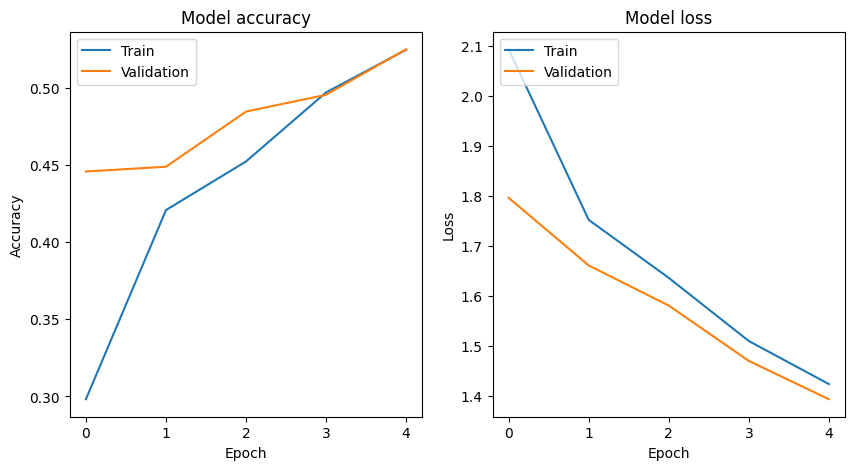

Loss: 2.9551
Accuracy: 0.1040


In [99]:
# prompt: evalueren de model

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step


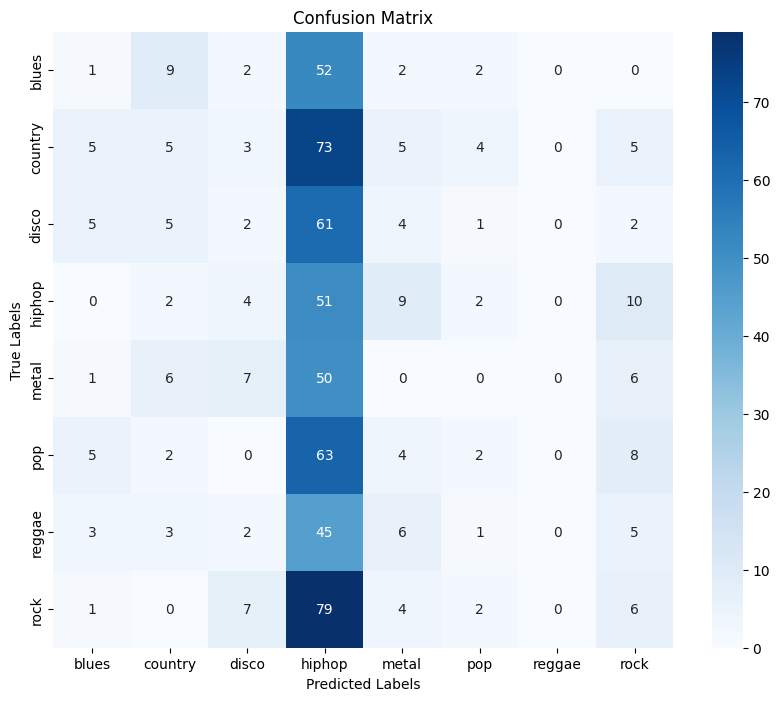

In [100]:
# prompt: confus matrix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [94]:
import numpy as np
import pandas as pd

def create_submission(pred, df_test, filename, label_encoder):
    """
    Creates a submission file for Kaggle test data with genre predictions.

    Args:
        pred (np.ndarray): Predicted probabilities or class indices.
        df_test (pd.DataFrame): Test dataframe containing filenames.
        filename (str): Output CSV filename (must include .csv).
        label_encoder (LabelEncoder): Trained label encoder to decode genre indices.

    Returns:
        pd.DataFrame: Submission dataframe.
    """
    # Als pred probabilities bevat → neem hoogste waarschijnlijkheid
    if pred.ndim > 1 and pred.shape[1] > 1:
        pred_classes = np.argmax(pred, axis=1)
    else:
        pred_classes = pred.reshape(-1)

    # Decode genre-namen
    genre_labels = label_encoder.inverse_transform(pred_classes[:len(df_test)])

    # Maak het submission DataFrame
    submission_df = pd.DataFrame({
        'filename': df_test['filename'].values[:len(genre_labels)],
        'genre': genre_labels
    })

    # Sla op
    submission_df.to_csv(filename, index=False)

    return submission_df

create_submission(y_pred, df_test, 'test.csv', label_encoder)

filename   genre
0    test.00000.wav  reggae
1    test.00001.wav   blues
2    test.00002.wav   disco
3    test.00003.wav   disco
4    test.00004.wav   disco
..              ...     ...
124  test.00124.wav  hiphop
125  test.00125.wav   metal
126  test.00126.wav   metal
127  test.00127.wav   metal
128  test.00128.wav   disco

[129 rows x 2 columns]

# Deep Learning Portfolio 1

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|michalreszkagniecki|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [LSTM voor audioclip](#Model1)
    - [LSTM voor songtekste](#Model2)
    - [Transformer voor songtekste](#Model3)
    - [Model naar keuze](#Model4)
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)
- [Submission functie](#Submission-functie)
- [HTML functie](#HTML-functie)

In [1]:
!pip install keras-tuner --upgrade
!pip install wordcloud
!pip install audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns
import PIL
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from PIL import Image
from sklearn.preprocessing import StandardScaler
from keras_tuner import HyperParameters  as hp
import keras_tuner as kt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models
import IPython.display as ipd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Masking
import librosa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
import pathlib


## Data Overview

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data importeren

In [4]:
import librosa
import librosa.display
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Pad naar de trainingsdata
base_dir = '/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/Train/'
genres = ['blues', 'country', 'disco', 'hiphop', 'metal', 'pop', 'reggae', 'rock']

# Parameters voor feature extractie
n_mfcc = 20
hop_length = 512
n_fft = 2048
sample_rate = 16000
duration = 10  # Duur van de audiofragmenten in seconden
n_samples = sample_rate * duration

# Lijsten om features en labels op te slaan
features = []
labels = []

# Loop door de genres en laad de audiobestanden
for i, genre in enumerate(genres):
    genre_path = os.path.join(base_dir, genre)
    for filename in os.listdir(genre_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(genre_path, filename)
            try:
                # Laad het audiobestand
                y, sr = librosa.load(file_path, sr=sample_rate, duration=duration)

                # Extraheer MFCC's
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

                # Transponeer de feature matrix zodat de tijd de eerste dimensie is
                mfccs = mfccs.T

                # Voeg de features en het label toe aan de lijsten
                features.append(mfccs)
                labels.append(genre)
            except Exception as e:
                print(f"Fout bij het verwerken van {file_path}: {e}")



In [5]:
# Converteer labels naar numerieke waarden
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)

# Pad de sequenties zodat ze allemaal dezelfde lengte hebben
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Bepaal de maximale lengte van de sequenties
max_len = max(len(seq) for seq in features)
padded_features = pad_sequences(features, maxlen=max_len, padding='post', truncating='post', dtype='float32')

# Splits de data in training- en testsets
X_train, X_test, y_train, y_test = train_test_split(padded_features, one_hot_labels, test_size=0.2, random_state=42)

# Bouw het LSTM model
model= Sequential([
    Masking(mask_value=0., input_shape=(padded_features.shape[1], padded_features.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),
    BatchNormalization(),
    Bidirectional(LSTM(units=64, recurrent_dropout=0.2)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])
# Compileer het model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print het modeloverzicht
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'Bidirectional' is not defined

In [ ]:


# Train het model
epochs = 20
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Evalueer het model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.1630 - loss: 2.3732 - val_accuracy: 0.2130 - val_loss: 1.9790
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.4991 - loss: 1.4684 - val_accuracy: 0.2222 - val_loss: 1.9509
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6577 - loss: 1.0924 - val_accuracy: 0.2593 - val_loss: 1.9290
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.7239 - loss: 0.8765 - val_accuracy: 0.2407 - val_loss: 1.8813
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8452 - loss: 0.6819 - val_accuracy: 0.2593 - val_loss: 1.8571
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8547 - loss: 0.5598 - val_accuracy: 0.2685 - val_loss: 1.8131
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9296 - loss: 0.3957 - val_accuracy: 0.3056 - val_loss: 1.8040
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9602 - loss: 0.2941 - val_accuracy: 0.2870 - val_loss:

In [ ]:
# prompt: ik wil de prediction oplssan maar alleen wat in df_test ook

import pandas as pd
import numpy as np
# Assuming X_test and y_test are defined from your previous code
# and model is the trained model

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create a DataFrame with true and predicted labels
df_results = pd.DataFrame({'true_label': y_true_classes, 'predicted_label': y_pred_classes})
df_results

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


true_label  predicted_label
0             7                2
1             1                2
2             5                5
3             1                2
4             6                1
..          ...              ...
103           1                4
104           5                0
105           5                3
106           4                4
107           7                0

[108 rows x 2 columns]

In [93]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/test.csv')

In [44]:
base_dir = '/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/Train/'
data_dir = pathlib.Path(base_dir)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    seed=0,
    output_sequence_length=5*22050,
    subset='both'
)

label_names = np.array(['blues', 'country', 'disco', 'hiphop', 'metal', 'pop', 'reggae', 'rock'])
print()
print("label names:", label_names)

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [45]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(label_names)  # Gebruik jouw array met genres


LabelEncoder()

In [46]:

# Verwijder de extra dimensie van de audio (batch, samples, channels=1) naar (batch, samples)
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [47]:

# import tensorflow_io as tfio  # Nodig voor betere audio support (optioneel)

def compute_mfcc(audio, labels, sample_rate=22050, num_mfcc=40):
    # Bereken de Short-Time Fourier Transform (STFT)
    stft = tf.signal.stft(audio, frame_length=1024, frame_step=512)
    spectrogram = tf.abs(stft)

    # Bereken de Mel-spectrogram
    num_spectrogram_bins = spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000.0, 40
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate,
        lower_edge_hertz, upper_edge_hertz)

    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate([num_mel_bins]))

    # Neem de log van de Mel-spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # Bereken MFCCs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :num_mfcc]

    return mfccs, labels


# Pas framing toe

train_ds_mfcc = train_ds.map(lambda x, y: compute_mfcc(x, y))

val_ds_mfcc = val_ds.map(lambda x, y: compute_mfcc(x, y))



In [48]:
def normalize_mfcc(mfcc, label):
    mean = tf.math.reduce_mean(mfcc, axis=0)
    std = tf.math.reduce_std(mfcc, axis=0)
    mfcc = (mfcc - mean) / (std + 1e-9)
    return mfcc, label
AUTOTUNE = tf.data.AUTOTUNE

train_ds_mfcc = train_ds_mfcc.map(lambda x, y: normalize_mfcc(x, y))
train_ds_mfcc = train_ds_mfcc.cache().prefetch(buffer_size=AUTOTUNE)

val_ds_mfcc = val_ds_mfcc.map(lambda x, y: normalize_mfcc(x, y))
val_ds_mfcc = val_ds_mfcc.cache().prefetch(buffer_size=AUTOTUNE)


In [49]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense # Import Bidirectional

model =  models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=16)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

# Compile het model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Corrected the typo here
    metrics=['accuracy']
)

# Print model samenvatting
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Train het model
history = model.fit(
    train_ds_mfcc, # Use the framed dataset for training
    validation_data=val_ds_mfcc, # Use the framed dataset for validation
    epochs=10
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.0694 - loss: 2.0918 - val_accuracy: 0.2523 - val_loss: 2.0357
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - accuracy: 0.3521 - loss: 1.9658 - val_accuracy: 0.2523 - val_loss: 1.9750
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 580ms/step - accuracy: 0.3806 - loss: 1.8795 - val_accuracy: 0.2897 - val_loss: 1.9065
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 614ms/step - accuracy: 0.3970 - loss: 1.7504 - val_accuracy: 0.2243 - val_loss: 1.8426
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - accuracy: 0.4728 - loss: 1.5778 - val_accuracy: 0.2710 - val_loss: 1.7703
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 658ms/step - accuracy: 0.5468 - loss: 1.3934 - val_accuracy: 0.3551 - val_loss: 1.7282
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 553ms/step - accuracy: 0.6197 - loss: 1.1796 - val_accuracy: 0.3645 - val_loss: 1.6914
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 584ms/step - accuracy: 0.7131 - loss: 0.9603 - val_accuracy: 0

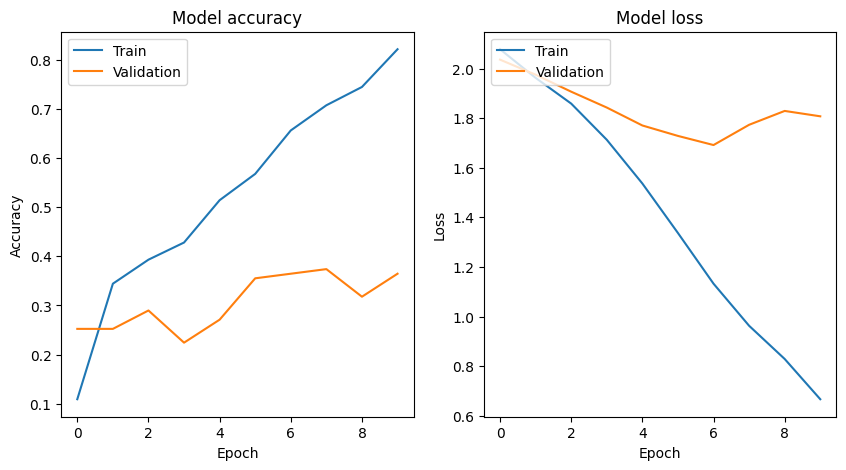

Validation Loss: 1.8073
Validation Accuracy: 0.3645


In [51]:
# prompt: Ik wil mijn resultaten evauleren

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(val_ds_mfcc, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step


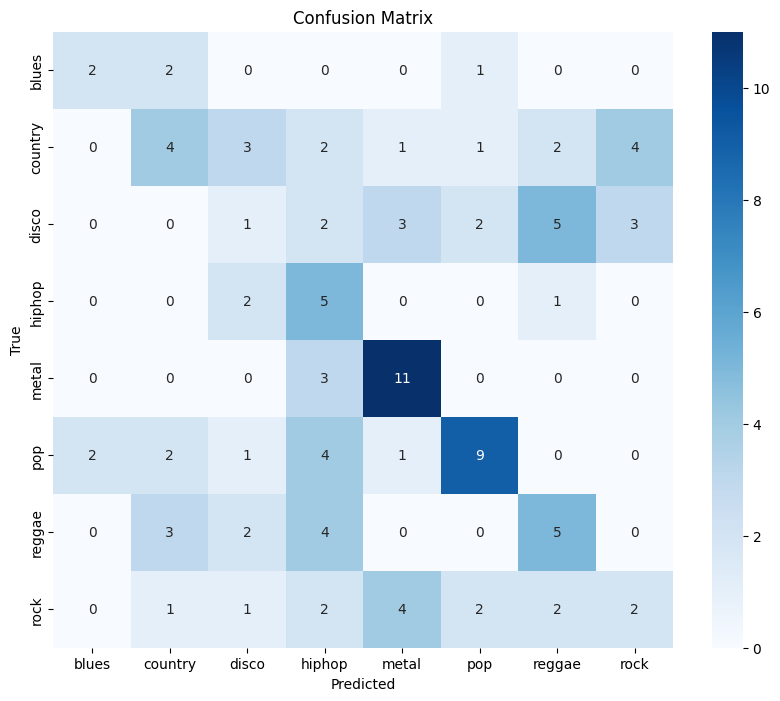

In [52]:
# prompt: confuix matrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'model' and 'val_ds_framed' are defined as in the original code
# and you have the predictions already.
# If not, replace with the actual prediction generation code

# Get predictions
y_pred = model.predict(val_ds_mfcc)
predicted_labels = np.argmax(y_pred, axis=1)

# Get true labels
true_labels = []
for _, labels in val_ds_mfcc:
  true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Exploratory Data Analysis

#### Train data

In [ ]:
df_train.head()

filename                                             lyrics  genre
0  blues.00001.wav  I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...  blues
1  blues.00002.wav  (John Lee Hooker)\nThink twice before you go, ...  blues
2  blues.00003.wav  [Intro, Spoken]\n...A little thing I'm going t...  blues
3  blues.00005.wav  Sugar mama, sugar mama, sugar mama please come...  blues
4  blues.00006.wav  My baby left me this morning\nPeople just arou...  blues

#### Test data

In [ ]:
df_test.head()

filename                                             lyrics
0  test.00000.wav  [Instrumental Intro]\n(Radio)\n(Radio)\n[Verse...
1  test.00001.wav  [Verse 1]\nThere's an old Kodak camera in my d...
2  test.00002.wav  [Intro]\nSo curious, so curious\n\n[Verse 1]\n...
3  test.00003.wav  [Intro]\nWhere do I take this pain of mine\nI ...
4  test.00004.wav  [Verse 1]\nBaby's into runnin' around, hangin'...

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  537 non-null    object
 1   lyrics    537 non-null    object
 2   genre     537 non-null    object
dtypes: object(3)
memory usage: 12.7+ KB


 De Data heeft 537 rijen met gegevens hebt, verdeeld over 3 kolommen: 'filename', 'lyrics' en 'genre'. Elke kolom bevat 537 niet-null waarden, wat betekent dat er geen missende data is. Het data type van alle kolommen is 'object', wat doorgaans betekent dat ze tekstuele data (strings) bevatten.

In [ ]:
df_train.describe()

filename                                             lyrics  \
count               537                                                537   
unique              537                                                500   
top     blues.00001.wav  [Intro: Lil' Kim, Mýa, Christina Aguilera & P!...   
freq                  1                                                  4   

       genre  
count    537  
unique     8  
top     rock  
freq      79

#### Count
- Er zijn 537 bestandsnamen.

#### Unique
- Er zijn 537 unieke bestandsnamen.
- Er zijn 500 unieke sets van lyrics.
- Er zijn 8 unieke genres in je dataset.

#### Freq
- De bestandsnaam "rock.00099.wav" komt 1 keer voor.
- De meest voorkomende lyrics komen 4 keer voor.
- Het genre "rock" komt 79 keer voor in je dataset.


### Missende waarde:

In [ ]:
df_train.isnull().sum()

filename    0
lyrics      0
genre       0
dtype: int64

De df_train heeft geen missende waarden.

### Kolommen beschrijving:

filename: is uniek voor elk nummer.

lyrics bevat songteksten, sommige teksten lijken intro’s, stukken tekst of gesproken tekst te bevatten.

genre bevat 8 unieke genres.
Het meest voorkomende genre is rock (79 keer).

### Verdeling van genres

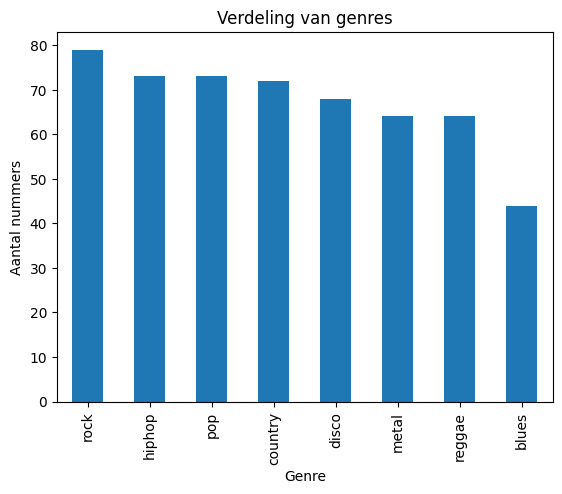

In [ ]:

# 1. Verdeling van genres
genre_counts = df_train['genre'].value_counts()

genre_counts.plot(kind='bar')
plt.title('Verdeling van genres')
plt.xlabel('Genre')
plt.ylabel('Aantal nummers')
plt.show()

De dataset vertoont een ongelijke verdeling van de muziekgenres. Het genre 'rock' is dominant en komt het meest frequent voor. 'Hiphop' en 'pop' vormen de op één na grootste categorieën. De overige genres ('country', 'disco', 'metal', 'reggae') zijn minder vertegenwoordigd, waarbij 'blues' significant de kleinste groep vormt. Deze disbalans in de genreverdeling kan relevant zijn voor downstream analyses en modeltraining.

### Woordwolken per genre

deze code genereert visuele woordwolken, één per muziekgenre in df_train. Elke woordwolk toont de meest gebruikte woorden in de songteksten van dat genre, waarbij grotere woorden vaker voorkomen. Dit geeft inzicht in de typische taal per genre.

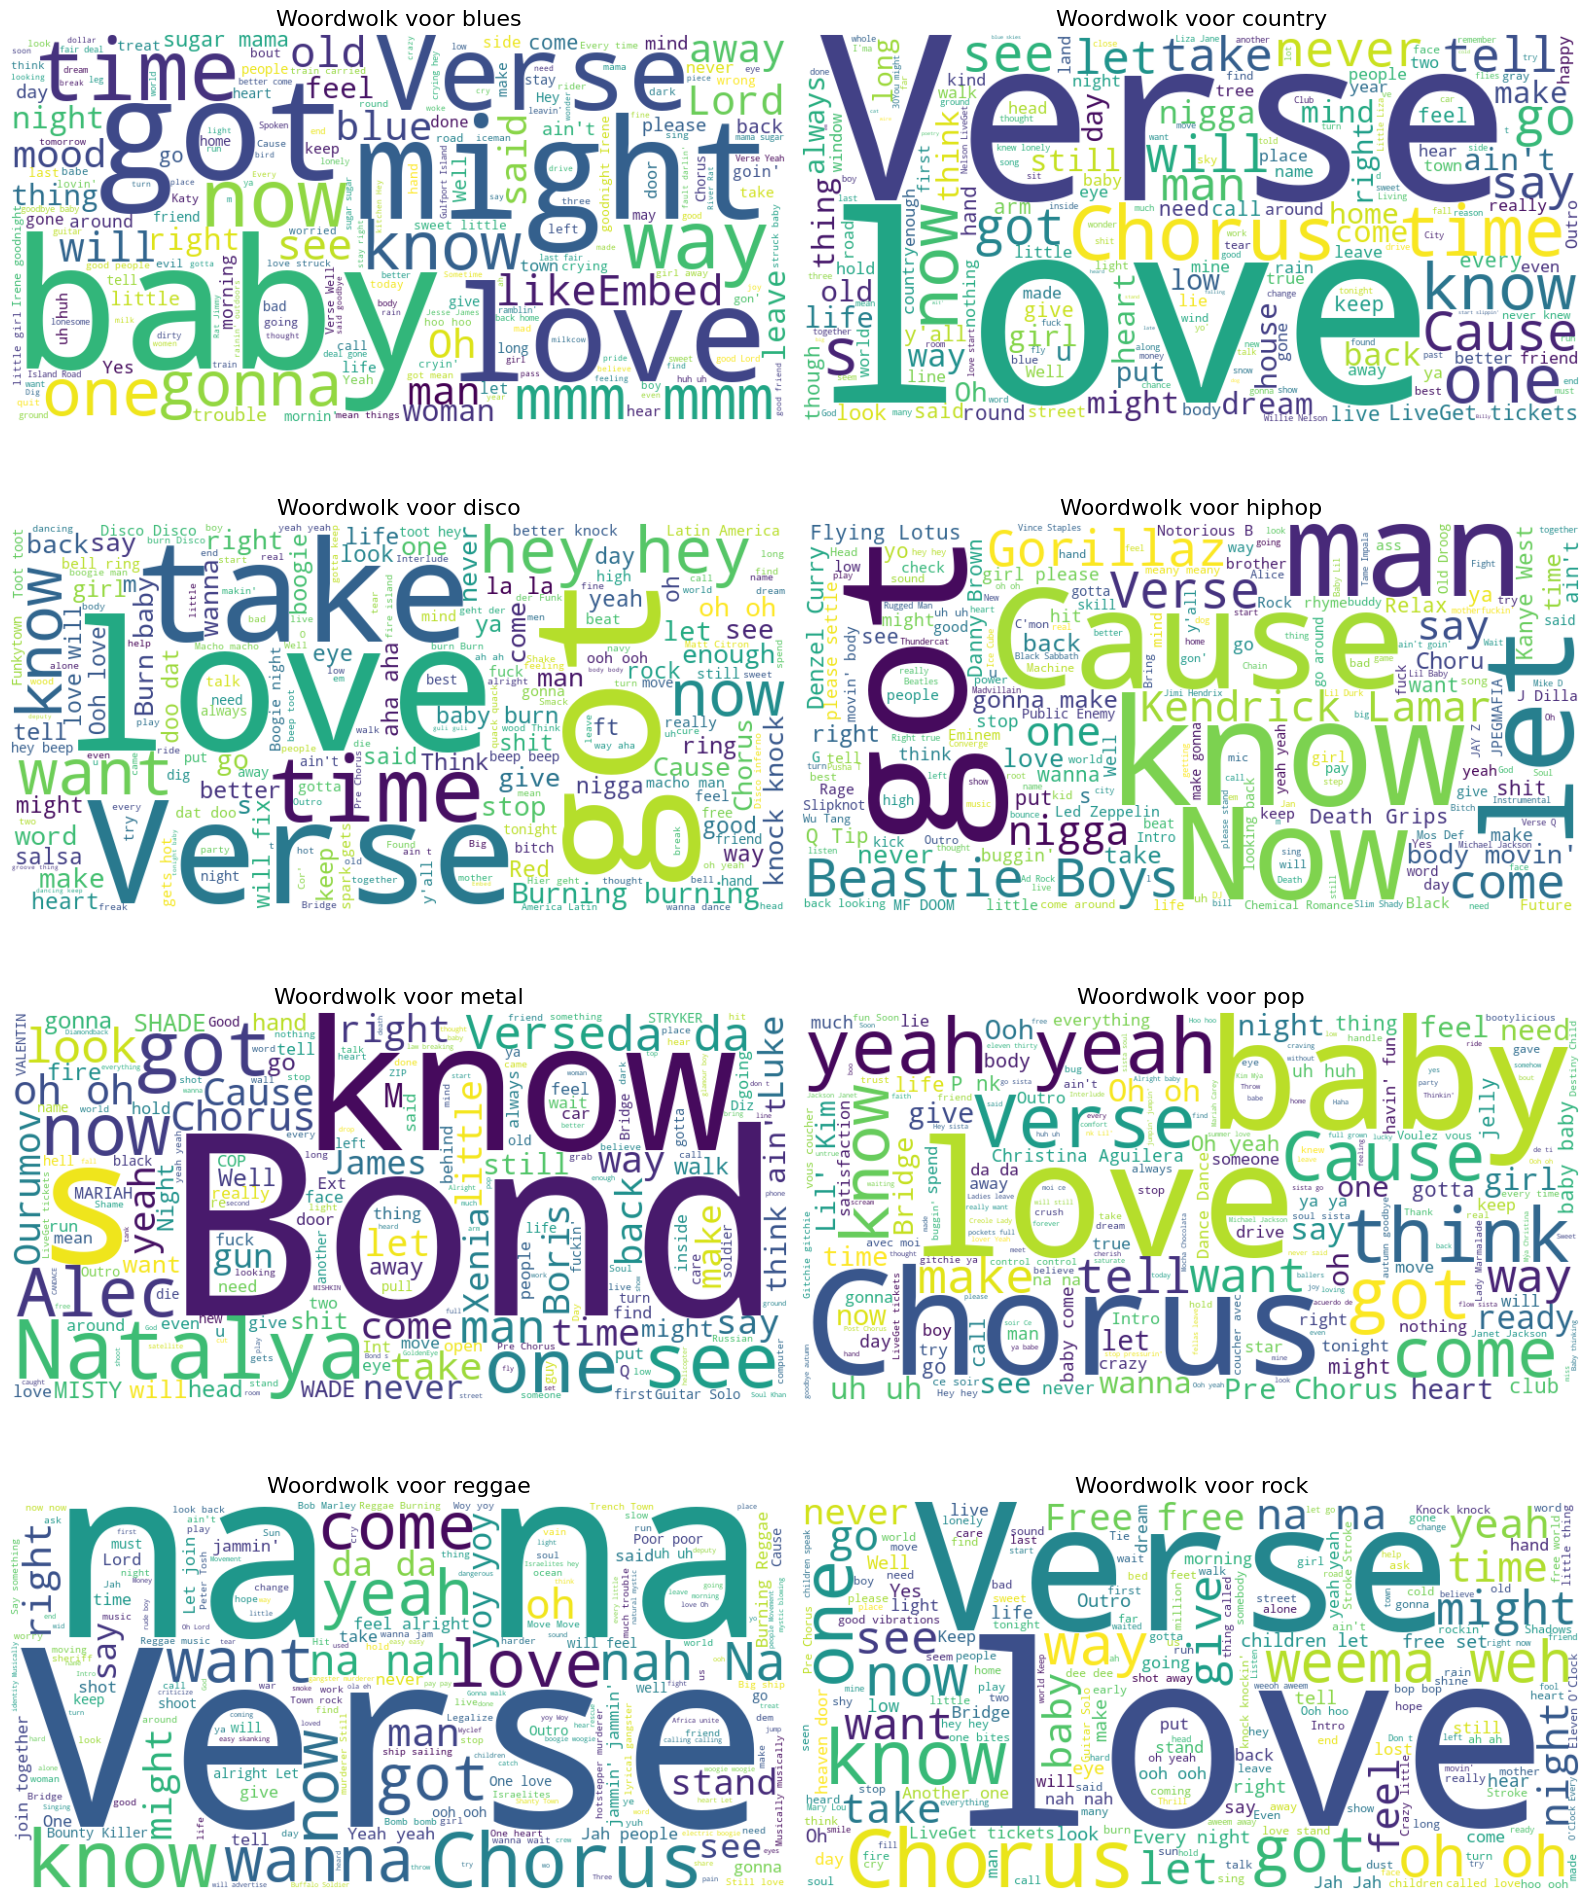

In [ ]:
# 3. Woordwolken per genre
genres = df_train['genre'].unique()
fig, axs = plt.subplots(len(genres)//2, 2, figsize=(16, 20))
axs = axs.flatten()

for i, genre in enumerate(genres):
    text = " ".join(df_train[df_train['genre'] == genre]['lyrics'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text) # Now WordCloud is defined
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f'Woordwolk voor {genre}', fontsize=16)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

 De code downloadt de lijst van Engelse stopwoorden en slaat deze op in de variabele stop_words,

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alr3m\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


De code geeft een DataFrame terug met de 10 meest voorkomende woorden per genre, samen met hun aantallen in de songteksten van dat genre. Het resultaat geeft inzicht in welke woorden frequent voorkomen in verschillende genres, zonder stopwoorden en te korte woorden.

In [ ]:
# Genres ophalen
genres = df_train['genre'].unique()

# Lijst om alles te verzamelen
top_words_data = []

# Voor elk genre: Top 10 woorden ophalen
for genre in genres:
    # Alle lyrics van dit genre combineren
    lyrics = " ".join(df_train[df_train['genre'] == genre]['lyrics']).lower()

    # Woorden extraheren
    words = re.findall(r'\b\w+\b', lyrics)

    # Stopwoorden en korte woorden verwijderen
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

    # Meest voorkomende woorden tellen
    most_common = Counter(filtered_words).most_common(10)

    # Data toevoegen aan de lijst
    for word, count in most_common:
        top_words_data.append({
            'Genre': genre,
            'Word': word,
            'Count': count
        })

# DataFrame maken
top_words_df = pd.DataFrame(top_words_data)
top_words_df.sort_values(by='Count', ascending=False)

Genre    Word  Count
40   metal    bond    470
50     pop    yeah    430
51     pop    baby    421
30  hiphop    like    415
31  hiphop     get    362
..     ...     ...    ...
5    blues    also     44
6    blues  little     40
7    blues    time     39
8    blues    like     37
9    blues    mama     32

[80 rows x 3 columns]

De code geeft een DataFrame terug waarin de woorden staan die in meerdere genres voorkomen, samen met het aantal genres waarin elk woord voorkomt. Dit kan helpen bij het identificeren van woorden die genre-overstijgend zijn en in verschillende muziekstijlen worden gebruikt.

In [ ]:
# Eerst: alle unieke combinaties woord + genre
word_genre_pairs = top_words_df[['Word', 'Genre']]

# Groeperen: per woord tellen in hoeveel genres het voorkomt
word_genre_counts = word_genre_pairs.groupby('Word')['Genre'].nunique().reset_index()

# Alleen woorden die in meerdere genres zitten
common_words = word_genre_counts[word_genre_counts['Genre'] > 1]

# Resultaat tonen
display(common_words.sort_values(by='Genre', ascending=False).head())


Word  Genre
16    like      8
18    love      6
30   verse      6
32    yeah      6
6   chorus      5

De code toont een DataFrame waarin elk woord staat dat in meer dan één genre voorkomt, samen met een lijst van de genres waarin dat specifieke woord voorkomt. Dit biedt gedetailleerde informatie over de spreiding van woorden over verschillende muziekgenres.

In [ ]:
# Genres per woord verzamelen
word_to_genres = top_words_df.groupby('Word')['Genre'].apply(list).reset_index()

# Alleen woorden met meerdere genres tonen
common_words_with_genres = word_to_genres[word_to_genres['Genre'].apply(lambda x: len(x) > 1)]

display(common_words_with_genres.head())


Word                                Genre
1     baby                  [blues, disco, pop]
6   chorus  [country, metal, pop, reggae, rock]
9      get                 [disco, hiphop, pop]
11     got        [blues, disco, hiphop, metal]
14    know        [hiphop, metal, reggae, rock]

Hier wordt er per genre een nummer afgespeeld

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Feature Engineering


De volgende features die aangemaakt worden zijn:
- Duration:
- Sample_rate:
- Spectral bandwidth:
- Spectral centroid:

In [ ]:
audio_features = []

# Loop through all files and extract features
for index, row in df_train.iterrows():
    filename = row['filename']
    file_path = os.path.join(base_dir, row['genre'], filename)

    # Load the audio file
    y, sr = librosa.load(file_path)

    # Calculate spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    bandwidth_mean = np.mean(spectral_bandwidth)
    bandwidth_std = np.std(spectral_bandwidth)

    # Calculate spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    centroid_mean = np.mean(spectral_centroid)
    centroid_std = np.std(spectral_centroid)

    # Store features and metadata in a dictionary
    features = {
        'filename': filename,
        'genre': row['genre'],
        'duration': librosa.get_duration(y=y, sr=sr),
        'sample_rate': sr,
        'spectral_bandwidth_mean': bandwidth_mean,
        'spectral_bandwidth_std': bandwidth_std,
        'spectral_centroid_mean': centroid_mean,
        'spectral_centroid_std': centroid_std
    }

    # Append the dictionary to the list
    audio_features.append(features)

# Create a Pandas DataFrame from the list of features
audio_features_df = pd.DataFrame(audio_features)

# Display the DataFrame (optional)
display(audio_features_df.head())

filename  genre   duration  sample_rate  spectral_bandwidth_mean  \
0  blues.00001.wav  blues  30.013333        22050              2038.987608   
1  blues.00002.wav  blues  30.013333        22050              1747.754087   
2  blues.00003.wav  blues  30.013333        22050              1596.422564   
3  blues.00005.wav  blues  30.013333        22050              1729.580804   
4  blues.00006.wav  blues  30.013333        22050              1389.068446   

   spectral_bandwidth_std  spectral_centroid_mean  spectral_centroid_std  
0              462.498760             1530.261767             613.119490  
1              276.216244             1552.832481             395.564168  
2              408.107638             1070.153418             429.378632  
3              449.272828             1832.011597            1015.127495  
4              430.297945             1459.469691             661.834571

### Visualisaties

In deze grafiek worden de boxplots per genre gevisualiseerd per genre

In deze grafiek worden er boxplots van de spectral features gevisualiseerd.

## Modeling

# LSTM voor audioclip

LSTM(Long short-term memory)

In [ ]:
import librosa
import pathlib

# ... (your previous code)

mfcc_features = []

# Get all files within the directory with glob
for path in data_dir.glob('**/*.wav'):  # Assuming your audio files are WAV format
    # Laad de audio
    y, sr = librosa.load(path, sr=None)

    # Genereer MFCC's (bijv. 13 coëfficiënten)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Transponeer zodat elke rij een tijdstap is (optioneel, afhankelijk van je modelinput)
    mfcc = mfcc.T

    mfcc_features.append(mfcc)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Padding van MFCC's
max_len = max([x.shape[0] for x in mfcc_features])
X_seq = pad_sequences(mfcc_features, maxlen=max_len, dtype='float32', padding='post')

# MFCC normaliseren (per kanaal)
original_shape = X_seq.shape
X_seq_reshaped = X_seq.reshape(-1, original_shape[-1])  # Flatten voor scaling
scaler_mfcc = StandardScaler()
X_seq_scaled = scaler_mfcc.fit_transform(X_seq_reshaped)
X_seq = X_seq_scaled.reshape(original_shape)  # Terug naar originele vorm

# Extra features
extra_features = audio_features_df[['duration', 'sample_rate',
                                  'spectral_bandwidth_mean', 'spectral_bandwidth_std',
                                  'spectral_centroid_mean', 'spectral_centroid_std']].values

# Normaliseren
scaler_extra = StandardScaler()
X_extra = scaler_extra.fit_transform(extra_features)

# Labels encoderen
le = LabelEncoder()
y = le.fit_transform(audio_features_df['genre'])
y_cat = to_categorical(y)

# Train/test split
X_seq_train, X_seq_test, X_extra_train, X_extra_test, y_train, y_test = train_test_split(
    X_seq, X_extra, y_cat, random_state=42)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, Concatenate, Dropout

# Define input layers outside the model definition
input_mfcc = Input(shape=(max_len, 13))
input_extra = Input(shape=(X_extra.shape[1],))

# Build the model using the defined input layers
x_mfcc = Masking(mask_value=0.)(input_mfcc)  # Apply masking to MFCC input
x_mfcc = LSTM(128, return_sequences=True)(x_mfcc)
x_mfcc = Dropout(0.2)(x_mfcc)
x_mfcc = LSTM(64)(x_mfcc)
x_mfcc = Dropout(0.2)(x_mfcc)

x_extra = Dense(128, activation='relu')(input_extra)
x_extra = Dropout(0.2)(x_extra)
x_extra = Dense(64, activation='relu')(x_extra)
x_extra = Dropout(0.2)(x_extra)

# Concatenate the outputs of the two branches
merged = Concatenate()([x_mfcc, x_extra])

# Add the final layers
output = Dense(32, activation='relu')(merged)
output = Dropout(0.2)(output)
output = Dense(16, activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(len(le.classes_), activation='softmax')(output)

# Create the model
model = Model(inputs=[input_mfcc, input_extra], outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1320, 13)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 1320, 13)  │          0 │ input_layer_11[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_3 (Masking) │ (None, 1320, 13)  │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_3 (Any)         │ (None, 1320)      │          0 │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 1320, 128) │     72,704 │ masking_3[0][0],  │
│                     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │        896 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 1320, 128) │          0 │ lstm_8[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 64)        │     49,408 │ dropout_14[0][0], │
│                     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      8,256 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128)       │          0 │ dropout_15[0][0], │
│ (Concatenate)       │                   │            │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      4,128 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 32)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │        528 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 16)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 8)         │        136 │ dropout_19[0][0]

 Total params: 136,056 (531.47 KB)

 Trainable params: 136,056 (531.47 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_seq_train, X_extra_train], y_train,
    validation_data=([X_seq_test, X_extra_test], y_test),
    epochs=50, batch_size=32
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.3802 - loss: 1.6208 - val_accuracy: 0.4000 - val_loss: 1.5914
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.3790 - loss: 1.6151 - val_accuracy: 0.4148 - val_loss: 1.5559
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4310 - loss: 1.5665 - val_accuracy: 0.4148 - val_loss: 1.5903
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.3863 - loss: 1.6206 - val_accuracy: 0.4370 - val_loss: 1.5871
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.4070 - loss: 1.5295 - val_accuracy: 0.3852 - val_loss: 1.5690
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4629 - loss: 1.4928 - val_accuracy: 0.4148 - val_loss: 1.5707
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4172 - loss: 1.5599 - val_accuracy: 0.4000 - val_loss: 1.5216
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.4299 - loss: 1.4728 - val_accuracy: 0.41

In [ ]:
loss, accuracy = model.evaluate([X_seq_test, X_extra_test], y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5101 - loss: 1.3543
Test loss: 1.3842
Test accuracy: 0.4963


In [ ]:
y_pred = model.predict([X_seq_test, X_extra_test])
len(y_pred)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


135

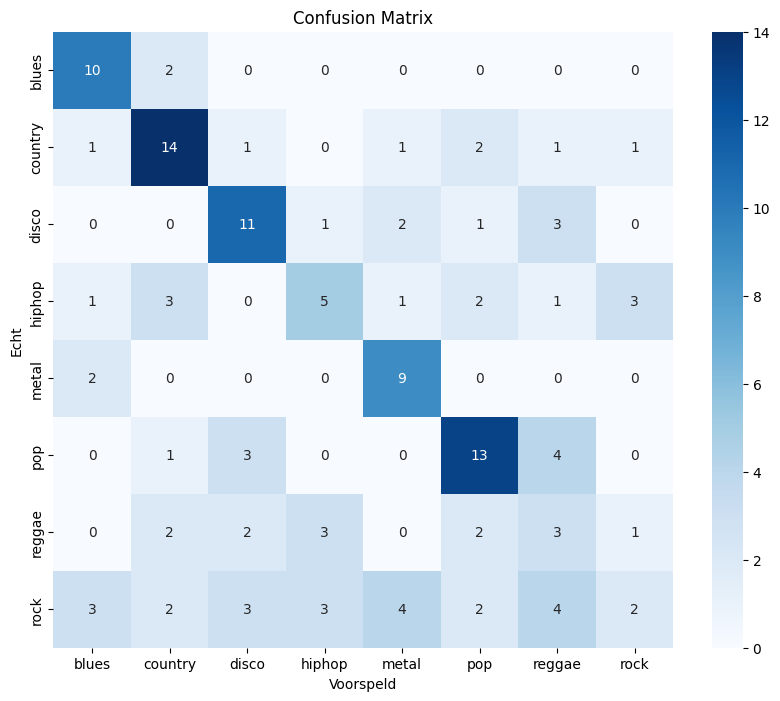

              precision    recall  f1-score   support

       blues       0.59      0.83      0.69        12
     country       0.58      0.67      0.62        21
       disco       0.55      0.61      0.58        18
      hiphop       0.42      0.31      0.36        16
       metal       0.53      0.82      0.64        11
         pop       0.59      0.62      0.60        21
      reggae       0.19      0.23      0.21        13
        rock       0.29      0.09      0.13        23

    accuracy                           0.50       135
   macro avg       0.47      0.52      0.48       135
weighted avg       0.47      0.50      0.47       135



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Voorspellingen
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Voorspeld')
plt.ylabel('Echt')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


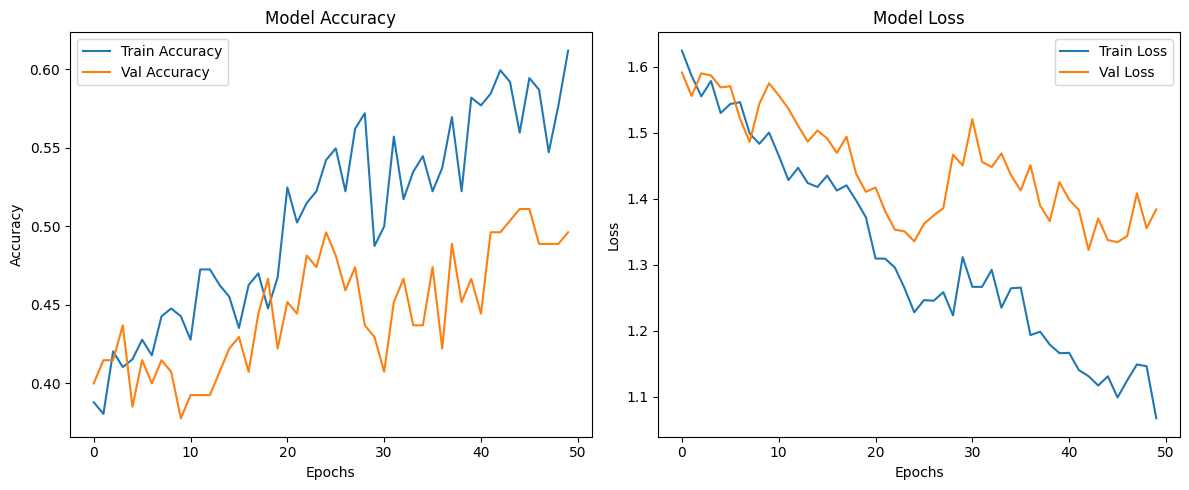

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#### Hypertuning

#### Modelarchitectuur

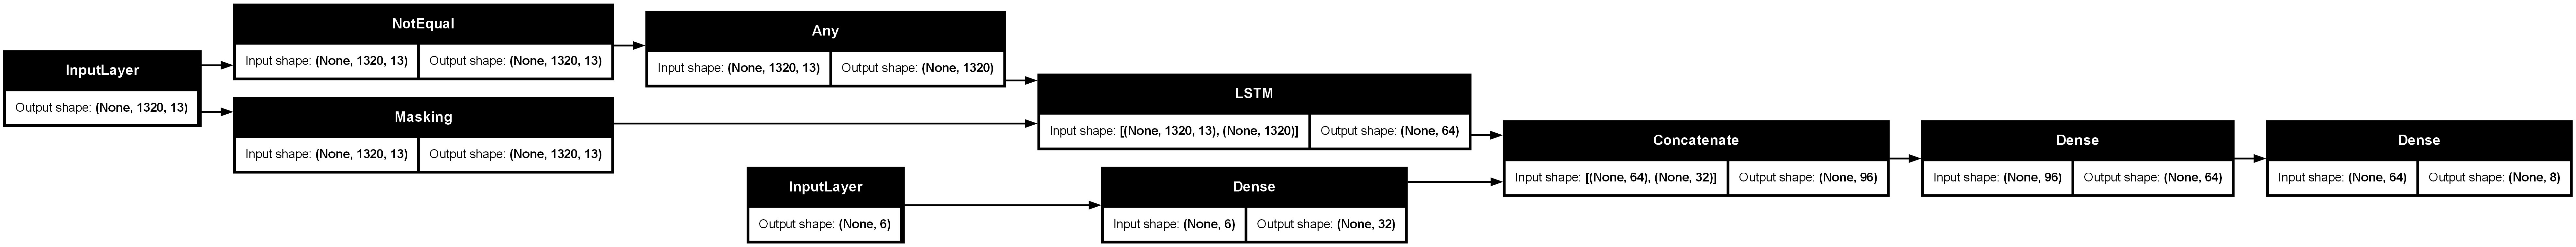

In [ ]:
plot_model(model, show_shapes=True, rankdir="LR")

#### Plot

#### Beste parameters  

# LSTM voor songtekste

In [ ]:
# Lyrics inladen

lyrics = df_train['lyrics'].values
genres = df_train['genre'].values

### Bepalen van vocabulary

In [ ]:
tokenizer = Tokenizer(num_words=8000)  # Pas num_words aan indien nodig
tokenizer.fit_on_texts(lyrics)
sequences = tokenizer.texts_to_sequences(lyrics)
vocab_size = len(tokenizer.word_index) + 1

### Bepalen van de sequence length

In [ ]:
# Bepalen van de sequence length (gebruik describe() voor inzicht)
df_subset = df_train.sample(n=200, random_state=42)
df_subset['seq_length'] = df_subset['lyrics'].astype(str).apply(lambda x: len(x.split()))
print(df_subset['seq_length'].describe())

# Aanpassen van max_length
max_length = int(df_subset['seq_length'].quantile(0.95)) # bijv. 95e percentiel
padded_sequences = pad_sequences(sequences, maxlen=max_length)

count      200.000000
mean       482.910000
std       1391.346299
min         44.000000
25%        197.000000
50%        270.500000
75%        451.500000
max      17073.000000
Name: seq_length, dtype: float64


In [ ]:
max_length = 640  # Pas max_length aan indien nodig
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(genres)

In [ ]:
from tensorflow.keras.layers import TextVectorization
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 640

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)


In [ ]:
# Train/test split (nu met consistente lengtes)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Verwijder leestekens
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Verwijder stopwoorden
    return text

df_train['processed_lyrics'] = df_train['lyrics'].apply(preprocess_text)

# Tokenizer
tokenizer = Tokenizer(num_words=5000)  # Pas num_words aan indien nodig
tokenizer.fit_on_texts(df_train['processed_lyrics'])
sequences = tokenizer.texts_to_sequences(df_train['processed_lyrics'])

# Padding
max_length = 400  # Pas max_length aan indien nodig
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Label encoding
le = LabelEncoder()
labels = le.fit_transform(df_train['genre'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(5000, 300, input_length=max_length))  # Pas embedding_dim aan indien nodig
model.add(LSTM(128))  # Pas units aan indien nodig
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\alr3m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))  # Pas epochs en batch_size aan indien nodig

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.1540 - loss: 2.0739 - val_accuracy: 0.2778 - val_loss: 2.0454
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.5071 - loss: 1.9071 - val_accuracy: 0.2593 - val_loss: 1.9479
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.6141 - loss: 1.4364 - val_accuracy: 0.3796 - val_loss: 1.9334
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.7953 - loss: 0.9802 - val_accuracy: 0.2870 - val_loss: 2.1165
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - accuracy: 0.8411 - loss: 0.5761 - val_accuracy: 0.3056 - val_loss: 1.9438
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.9482 - loss: 0.2736 - val_accuracy: 0.3056 - val_loss: 2.0773
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.9754 - loss: 0.1286 - val_accuracy: 0.3148 - val_loss: 2.0896
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.9960 - loss: 0.0691 - val_accuracy: 0.

#### Hypertuning

#### Modelarchitectuur

Van BERT de enige toegepaste modellen voor onze opdracht zijn moddellen in het engels, getraind op zowel lower als uppercase. Bovendien

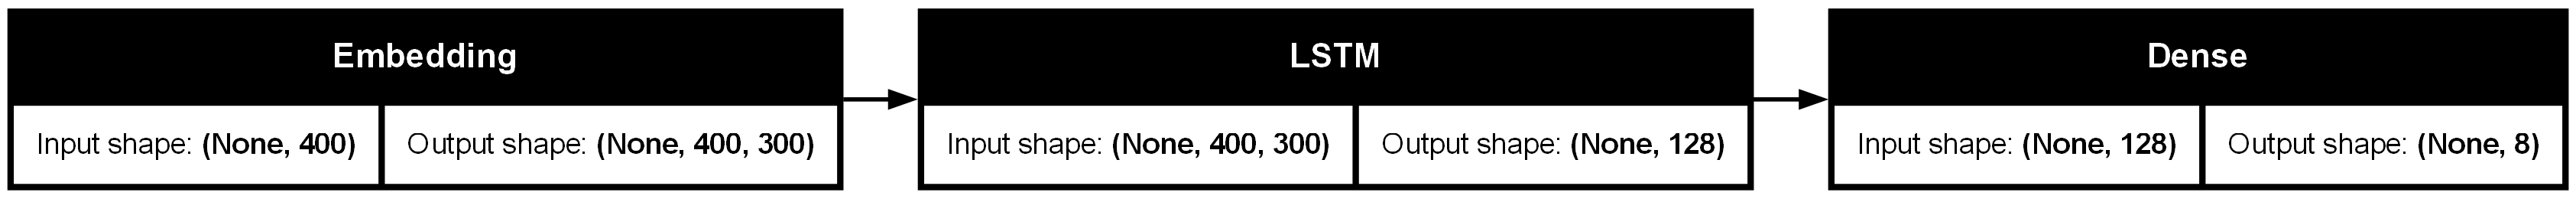

In [ ]:
plot_model(model, show_shapes=True, rankdir="LR")

#### Plot

#### Beste parameters  

# Transformer voor songtekste

#### Hypertuning

#### Modelarchitectuur

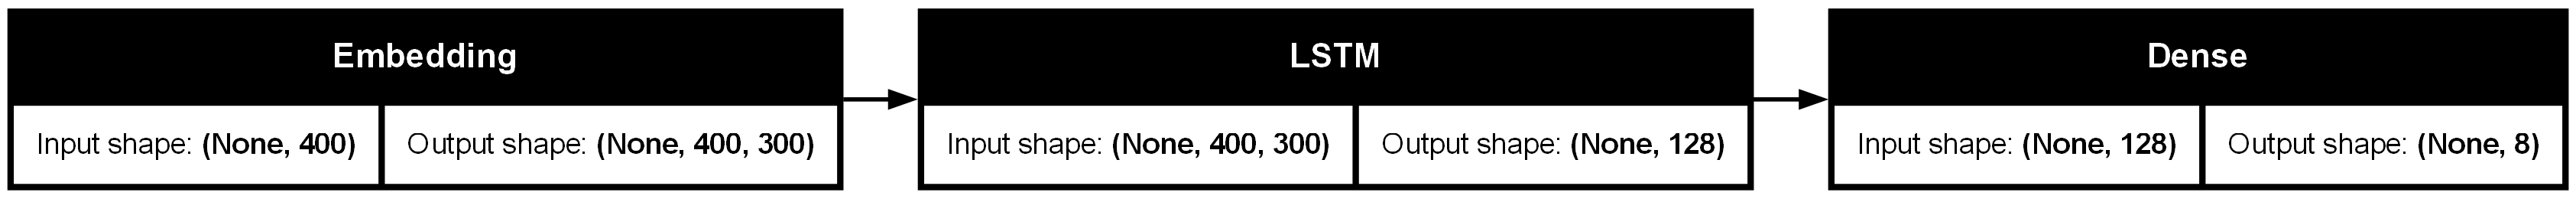

In [ ]:
plot_model(model, show_shapes=True, rankdir="LR")

#### Plot

#### Beste parameters  

# Model naar keuze

### Model code

#### Modelarchitectuur

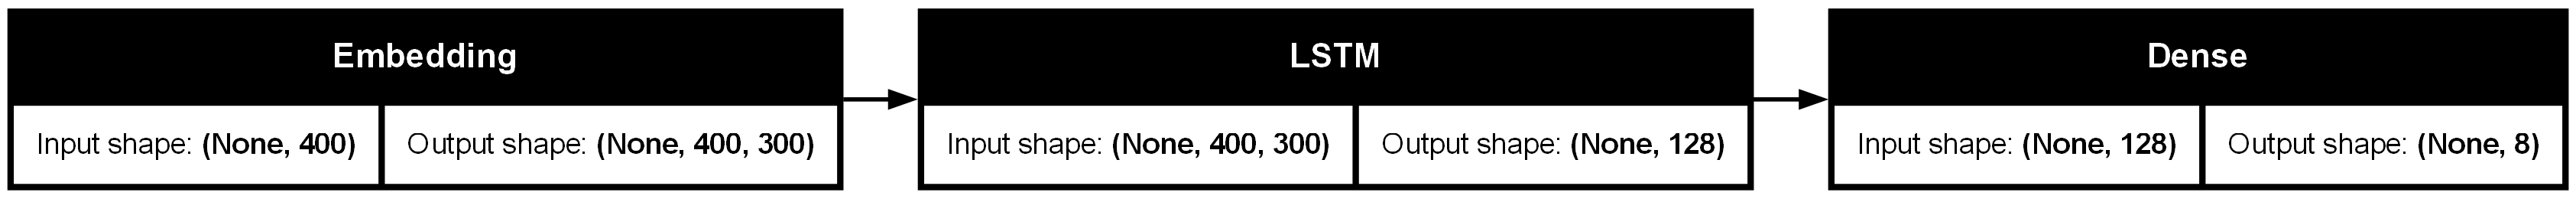

In [ ]:
plot_model(model, show_shapes=True, rankdir="LR")

#### Plot

### Hypertuning

#### Beste parameters



## Results

### Overview

### Scores

## Conclusion & Advice

|Model|Notebook|Kaggle|
|----|------|------|
||||
||||
||||
||||

### Submission functie

In [ ]:
import numpy as np
import pandas as pd

def create_submission(pred, df_test, filename, label_encoder):
    """
    Creates a submission file for Kaggle test data with genre predictions.

    Args:
        pred (np.ndarray): Predicted probabilities or class indices.
        df_test (pd.DataFrame): Test dataframe containing filenames.
        filename (str): Output CSV filename (must include .csv).
        label_encoder (LabelEncoder): Trained label encoder to decode genre indices.

    Returns:
        pd.DataFrame: Submission dataframe.
    """
    # Als pred probabilities bevat → neem hoogste waarschijnlijkheid
    if pred.ndim > 1 and pred.shape[1] > 1:
        pred_classes = np.argmax(pred, axis=1)
    else:
        pred_classes = pred.reshape(-1)

    # Decode genre-namen
    genre_labels = label_encoder.inverse_transform(pred_classes[:len(df_test)])

    # Maak het submission DataFrame
    submission_df = pd.DataFrame({
        'filename': df_test['filename'].values[:len(genre_labels)],
        'genre': genre_labels
    })

    # Sla op
    submission_df.to_csv(filename, index=False)

    return submission_df



In [ ]:
create_submission(y_pred, df_test, 'test.csv', label_encoder)

filename    genre
0    test.00000.wav   hiphop
1    test.00001.wav    disco
2    test.00002.wav    blues
3    test.00003.wav   hiphop
4    test.00004.wav   hiphop
..              ...      ...
124  test.00124.wav    disco
125  test.00125.wav     rock
126  test.00126.wav    disco
127  test.00127.wav      pop
128  test.00128.wav  country

[129 rows x 2 columns]

## Sources

### Html

In [ ]:
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving Portfolio_1.ipynb to Portfolio_1.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import librosa
import librosa.display
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Pad naar de trainingsdata
base_dir = '/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/Train/'
genres = ['blues', 'country', 'disco', 'hiphop', 'metal', 'pop', 'reggae', 'rock']

# Parameters voor feature extractie
n_mfcc = 20
hop_length = 512
n_fft = 2048
sample_rate = 22050
duration = 10  # Gebruik alleen de eerste 10 seconden
n_samples = sample_rate * duration

# Lijsten om features en labels op te slaan
features = []
labels = []

# Loop door de genres en laad de audiobestanden
for i, genre in enumerate(genres):
    genre_path = os.path.join(base_dir, genre)
    for filename in os.listdir(genre_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(genre_path, filename)
            try:
                # Laad het audiobestand (alleen de eerste 'duration' seconden)
                y, sr = librosa.load(file_path, sr=sample_rate, duration=duration)

                # Extraheer MFCC's
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

                # Transponeer de feature matrix zodat de tijd de eerste dimensie is
                mfccs = mfccs.T

                # Voeg de features en het label toe aan de lijsten
                features.append(mfccs)
                labels.append(genre)
                # print(f"Verwerkt: {file_path}")
            except Exception as e:
                print(f"Fout bij het verwerken van {file_path}: {e}")


In [6]:
# Converteer labels naar numerieke waarden
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)

# Pad de sequenties zodat ze allemaal dezelfde lengte hebben
max_len = max(len(seq) for seq in features)
padded_features = pad_sequences(features, maxlen=max_len, padding='post', truncating='post', dtype='float32')

# Splits de data in training- en testsets
X_train, X_test, y_train, y_test = train_test_split(padded_features, one_hot_labels, test_size=0.2, random_state=42)



In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2

def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),
        Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.4, kernel_regularizer=l2(0.001))),
        BatchNormalization(),
        Dropout(0.4),
        Bidirectional(LSTM(units=64, recurrent_dropout=0.4, kernel_regularizer=l2(0.001))),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
    ])
    return model

# Assumptie: X_train.shape[1] is de maximale sequentielengte, X_train.shape[2] is het aantal features (n_mfcc)
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(genres)

model = create_lstm_model(input_shape, num_classes)

# Compileer het model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print het modeloverzicht
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 431, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 431, 256)       │       152,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 431, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 431, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,496 (1.22 MB)

 Trainable params: 318,728 (1.22 MB)

 Non-trainable params: 768 (3.00 KB)

In [8]:
# Train het model met Early Stopping
epochs = 15
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Evalueer het model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.2071 - loss: 3.3717 - val_accuracy: 0.2593 - val_loss: 2.5239
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.4111 - loss: 2.4340 - val_accuracy: 0.3056 - val_loss: 2.4558
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5264 - loss: 1.9888 - val_accuracy: 0.3148 - val_loss: 2.4217
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6098 - loss: 1.7668 - val_accuracy: 0.2685 - val_loss: 2.3830
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.6170 - loss: 1.6715 - val_accuracy: 0.2963 - val_loss: 2.3680
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7003 - loss: 1.4663 - val_accuracy: 0.3056 - val_loss: 2.2988
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7472 - loss: 1.3527 - val_accuracy: 0.3333 - val_loss: 2.2796
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7230 - loss: 1.3102 - val_accuracy: 0.3519 - val_loss:

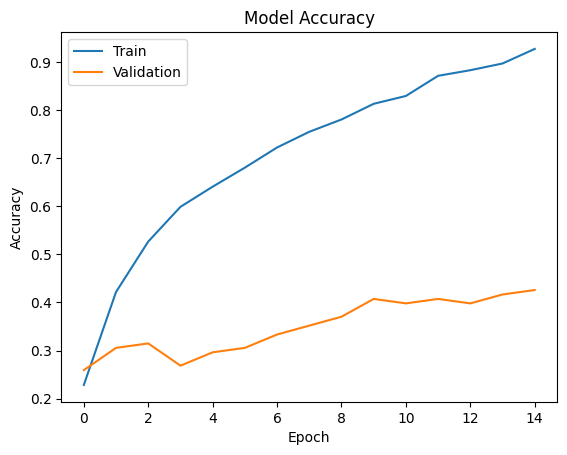

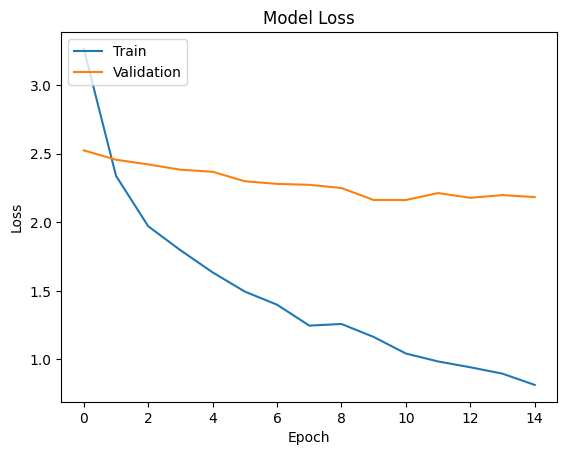

In [9]:
# prompt: maak een plot

import matplotlib.pyplot as plt

# Assuming 'history' is the training history object from your model.fit() call
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


ImportError: cannot import name 'TimeShift' from 'audiomentations' (/usr/local/lib/python3.11/dist-packages/audiomentations/__init__.py)

In [15]:
!pip install --upgrade audiomentations

In [16]:
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from audiomentations import AddGaussianNoise, TimeShift

# Pad naar de trainingsdata
base_dir = '/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/Train/'
genres = ['blues', 'country', 'disco', 'hiphop', 'metal', 'pop', 'reggae', 'rock']
sample_rate = 22050
duration = 10
n_mfcc = 20
hop_length = 512
n_fft = 2048
num_classes = len(genres)

def load_and_extract_features(file_path, duration=duration, sr=sample_rate, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft).T
    return mfccs

def data_generator(files, labels, batch_size, is_training=False):
    num_samples = len(files)
    noise_augment = AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    time_shift_augment = TimeShift(min_fraction=-0.2, max_fraction=0.2, p=0.5, sample_rate=sample_rate)

    while True:
        indices = np.random.permutation(num_samples)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]

            batch_features = []
            batch_labels = []
            batch_files = [files[i] for i in batch_indices]
            batch_raw_labels = [labels[i] for i in batch_indices]

            for i, file_path in enumerate(batch_files):
                try:
                    features = load_and_extract_features(file_path)
                    audio, _ = librosa.load(file_path, sr=sample_rate, duration=duration)

                    if is_training:
                        augmented_audio = noise_augment(samples=audio, sample_rate=sample_rate)
                        augmented_audio = time_shift_augment(samples=augmented_audio, sample_rate=sample_rate)
                        augmented_features = librosa.feature.mfcc(y=augmented_audio, sr=sample_rate, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft).T
                        batch_features.append(augmented_features)
                    else:
                        batch_features.append(features)

                    batch_labels.append(batch_raw_labels[i])

                except Exception as e:
                    print(f"Fout bij het laden of verwerken van {file_path}: {e}")
                    continue

            padded_batch_features = pad_sequences(batch_features, padding='post', truncating='post', dtype='float32')
            one_hot_batch_labels = to_categorical(batch_labels, num_classes=num_classes)
            yield padded_batch_features, one_hot_batch_labels

# Laad alle bestanden en labels
all_files = []
all_labels_str = []
for i, genre in enumerate(genres):
    genre_path = os.path.join(base_dir, genre)
    for filename in os.listdir(genre_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(genre_path, filename)
            all_files.append(file_path)
            all_labels_str.append(genre)

# Converteer string labels naar numerieke labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(all_labels_str)

# Splits de data in training en test sets
train_files, test_files, train_labels, test_labels = train_test_split(all_files, numeric_labels, test_size=0.2, random_state=42)

batch_size = 32
train_generator = data_generator(train_files, train_labels, batch_size, is_training=True)
validation_generator = data_generator(test_files, test_labels, batch_size, is_training=False)

# Bereken het aantal stappen per epoch
train_steps_per_epoch = len(train_files) // batch_size
validation_steps_per_epoch = len(test_files) // batch_size

# Bouw het LSTM model (gebruik de modelarchitectuur met regularisatie)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2

def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),
        Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.4, kernel_regularizer=l2(0.001))),
        BatchNormalization(),
        Dropout(0.4),
        Bidirectional(LSTM(units=64, recurrent_dropout=0.4, kernel_regularizer=l2(0.001))),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
    ])
    return model

# Bepaal de input shape (we moeten een voorbeeld genereren om de feature shape te krijgen)
temp_generator = data_generator(train_files[:1], train_labels[:1], batch_size=1, is_training=True)
temp_features, _ = next(temp_generator)
input_shape = (temp_features.shape[1], temp_features.shape[2])

model = create_lstm_model(input_shape, num_classes)

# Compileer het model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print het modeloverzicht
model.summary()

# Train het model met Early Stopping
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps_per_epoch,
    callbacks=[early_stopping]
)

# Evalueer het model
loss, accuracy = model.evaluate(validation_generator, steps=validation_steps_per_epoch, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot de trainingsgeschiedenis
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

ImportError: cannot import name 'TimeShift' from 'audiomentations' (/usr/local/lib/python3.11/dist-packages/audiomentations/__init__.py)